## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [2]:
df = pd.read_csv('../data/processed/encoded_labels/_types_of_private_sector.csv')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       '_types_of_private_sector', 'capital_providers',
       'entrepreneurs_manufacturing_firms_investors',
       'financial_intermediaries_and_market_facilitators',
       'individuals_entrepeneurs', 'individuals_entrepreneurs',
       'iron_and_steel', 'large_corporations',
       'manufacturers_building_professionals', 'no tag', 'non_grant_pilot',
       'poultry_fisheries_dairy_horticulture_khadi_homespun_cloth_and_silk_weaving_bamboo_and_commercial_cooking',
       'retailers_manufacturers', 'small_and_medium_sized_enterprises',
       'sugarcane_mills'],
      dtype='object')

In [3]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', '_types_of_private_sector'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,capital_providers,91
1,entrepreneurs_manufacturing_firms_investors,1
2,financial_intermediaries_and_market_facilitators,24
3,individuals_entrepeneurs,1
4,individuals_entrepreneurs,80
5,iron_and_steel,1
6,large_corporations,30
7,manufacturers_building_professionals,1
8,no tag,377
9,non_grant_pilot,2


Text(0.5, 0, 'category')

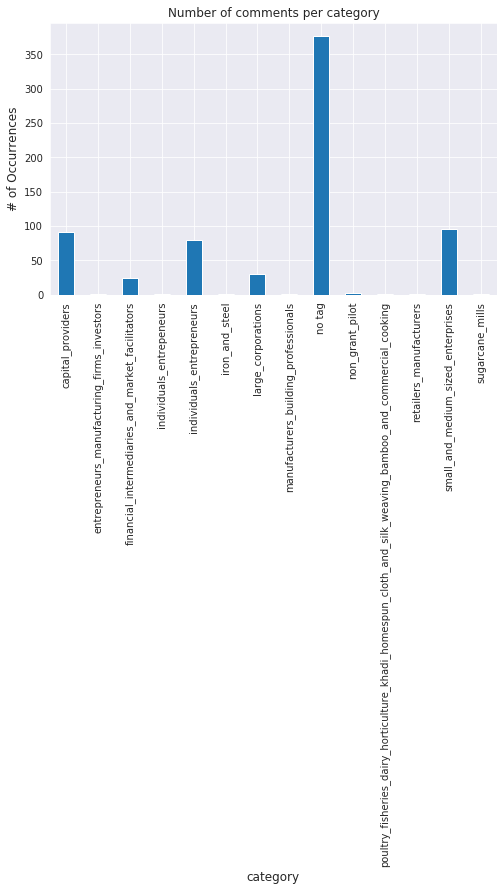

In [4]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

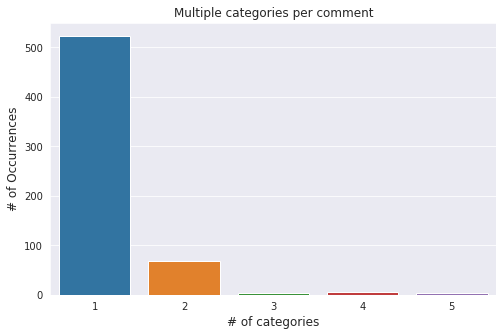

In [5]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

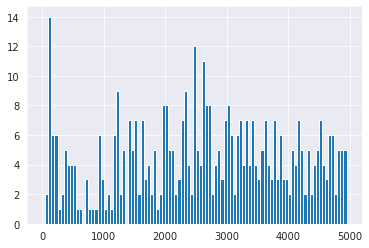

In [6]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [7]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [8]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       '_types_of_private_sector', 'capital_providers',
       'entrepreneurs_manufacturing_firms_investors',
       'financial_intermediaries_and_market_facilitators',
       'individuals_entrepeneurs', 'individuals_entrepreneurs',
       'iron_and_steel', 'large_corporations',
       'manufacturers_building_professionals', 'no tag', 'non_grant_pilot',
       'poultry_fisheries_dairy_horticulture_khadi_homespun_cloth_and_silk_weaving_bamboo_and_commercial_cooking',
       'retailers_manufacturers', 'small_and_medium_sized_enterprises',
       'sugarcane_mills'],
      dtype='object')

##  Features engineering

In [9]:
categories = ['capital_providers',
       'entrepreneurs_manufacturing_firms_investors',
       'financial_intermediaries_and_market_facilitators',
       'individuals_entrepeneurs', 'individuals_entrepreneurs',
       'iron_and_steel', 'large_corporations',
       'manufacturers_building_professionals', 'no tag', 'non_grant_pilot',
       'poultry_fisheries_dairy_horticulture_khadi_homespun_cloth_and_silk_weaving_bamboo_and_commercial_cooking',
       'retailers_manufacturers', 'small_and_medium_sized_enterprises',
       'sugarcane_mills']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [10]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                                                                                                </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>capital_providers                                                                                       </td><td style="text-align: right;">       91</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.8944444444444445    
 0.8777777777777778    
 0.8666666666666667    
 0.8555555555555555   <br> 
 0.8    <br>
 0.8611111111111112                 </td><td>0.8063909774436091   
 0.7815009692605926   
 0.7548387096774194   
 0.7328157113496232   
 0.7079422888359714   
 0.7448216340621404                  </td><td>0.7977848823932405    
 0.7321306234300069    
 0.7255081068737155    
 0.7328157113496232    
 0.8390043388901576    
 0.6943366065311716               </td><td>0.801980198019802    
 0.7527472527472527    
 0.738562091503268    
 0.7328157113496232    
 0.7292780748663101    
 0.7144488863506568           </td></tr>
<tr><td>entrepreneurs_manufacturing_firms_investors                                                             </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
<tr><td>financial_intermediaries_and_market_facilitators                                                        </td><td style="text-align: right;">       24</td><td>AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor              </td><td>0.9666666666666667    
 0.9611111111111111    
 0.8611111111111112    
 0.9722222222222222    
 0.9722222222222222    
 0.9722222222222222                 </td><td>0.6914285714285715   
 0.6580459770114943   
 0.5681390977443609   
 0.4861111111111111   
 0.4861111111111111   
 0.4861111111111111                  </td><td>0.6914285714285715    
 0.6885714285714286    
 0.8314285714285714  <br>  
 0.5    <br>
 0.5    <br>
 0.5              </td><td>0.6914285714285715    
 0.6717895285230528    
 0.5829858215179317    
 0.4929577464788732    
 0.4929577464788732    
 0.4929577464788732           </td></tr>
<tr><td>individuals_entrepeneurs                                                                                </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0                  </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0           </td></tr>
<tr><td>individuals_entrepreneurs                                                                               </td><td style="text-align: right;">       80</td><td>AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Random Forest    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent              </td><td>0.8333333333333334    
 0.7388888888888889    
 0.8277777777777777    
 0.8555555555555555    
 0.5333333333333333    
 0.8166666666666667                 </td><td>0.6011904761904762   
 0.496117835122174   
 0.4991742361684558   
 0.42777777777777776   
 0.5175655616031668   
 0.42485549132947975                  </td><td>0.5509490509490509    
 0.49575424575424576    
 0.49975024975024973    <br>
 0.5    <br>
 0.5354645354645354    
 0.4772727272727273               </td><td>0.5586793069630598    
 0.4956780923994039    
 0.48290241868223527    
 0.4610778443113772    
 0.4556451612903226    
 0.44954128440366975           </td></tr>
<tr><td>iron_and_steel                                                                                          </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0                  </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0           </td></tr>
<tr><td>large_corporations                                                                                      </td><td style="text-align: right;">       30</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9666666666666667    
 0.8833333333333333    
 0.9666666666666667    
 0.9555555555555556    <br>
 0.95    <br>
 0.9166666666666666                 </td><td>0.7359550561797753   
 0.5619946091644205   
 0.48333333333333334   
 0.48314606741573035   
 0.4830508474576271   
 0.4824561403508772                  </td><td>0.5804597701149425    
 0.6982758620689655    <br>
 0.5    <br>
 0.4942528735632184    
 0.49137931034482757    
 0.47413793103448276               </td><td>0.6164772727272727    
 0.5795795795795796    
 0.4915254237288135    
 0.48863636363636365    
 0.48717948717948717    
 0.47826086956521735           </td></tr>
<tr><td>manufacturers_building_professionals                                                                    </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9944444444444445                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5                  </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49722222222222223               </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4986072423398329           </td></tr>
<tr><td>no tag                                                                                                  </td><td style="text-align: right;">      377</td><td>Gaussian Naive Bayes    
 Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.75  <br>  
 0.75    <br>
 0.7444444444444445    
 0.7222222222222222    
 0.7111111111111111    
 0.65                 </td><td>0.7289870689655172   
 0.7296495195025439   
 0.7243636363636363   
 0.7007442224833529   
 0.6850909090909091   
 0.6198814655172413                  </td><td>0.7274247491638797    
 0.717391304347826    
 0.7063545150501672    
 0.705685618729097    
 0.6702341137123746    
 0.6190635451505017               </td><td>0.7281787979462399    
 0.7221364618709478    <br>
 0.7125    <br>
 0.7028133667943468 <br>   
 0.675    <br>
 0.6194503171247356           </td></tr>
<tr><td>non_grant_pilot                                                                                         </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9888888888888889                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.4972067039106145   <br>               </td><td>0.5   <br> 
 0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4972067039106145               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4972067039106145           </td></tr>
<tr><td>poultry_fisheries_dairy_horticulture_ <br> khadi_homespun_cloth_and_silk_ <br> weaving_bamboo_and_commercial_cooking</td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
<tr><td>retailers_manufacturers                                                                                 </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9944444444444445                 </td><td>1.0  <br> 
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5                  </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49722222222222223               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4986072423398329           </td></tr>
<tr><td>small_and_medium_sized_enterprises                                                                      </td><td style="text-align: right;">       95</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 AdaBoost    
 Random Forest              </td><td>0.8055555555555556  <br>  
 0.8    <br>
 0.7722222222222223    
 0.8555555555555555<br>    
 0.85    <br>
 0.8833333333333333                 </td><td>0.5935150375939849   
 0.5773420479302832   
 0.5662771958098308   
 0.6081871345029239   
 0.5911764705882353   
 0.9410112359550562                  </td><td>0.6102187759623373    
 0.5884796455275547    
 0.5911104957075602    
 0.5461091110495707    
 0.5429243976737745    
 0.5434782608695652               </td><td>0.6002284408909195    
 0.5819354838709678    
 0.5726941115164148    
 0.5541158536585367    
 0.5496246872393661    
 0.5486567164179105           </td></tr>
<tr><td>sugarcane_mills                                                                                         </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
</tbody>
</table>